In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
# plt.style.use("ggplot")

%matplotlib inline

p = sns.color_palette()
sns.set_style("darkgrid", {"font.sans-serif": ['simhei', 'Arial']})

因为各个数据文件间设计时间的先后，具体处理会放到数据预处理  
此处仅仅是为了对数据整体有一个全面的认识

文件组成：
1.	用户的基本属性user_info.txt
	> 共6个字段，其中字段性别为1表示性别未知。
	- 字段组成：
        - 用户id
        - 性别
        - 职业
        - 教育程度
        - 婚姻状态
        - 户口类型
2.	银行流水记录bank_detail.txt
	> 共5个字段，其中，第2个字段，时间戳为0表示时间未知；第3个字段，交易类型有两个值，1表示支出、0表示收入；第5个字段，工资收入标记为1时，表示工资收入。
	字段组成：
	- 用户id,
        - 间戳
        - 交易类型
        - 交易金额
        - 工资收入标记
3.	用户浏览行为browse_history.txt
	> 共4个字段。其中，第2个字段，时间戳为0表示时间未知
	- 字段组成：
        - 用户id
        - 时间戳
        - 浏览行为数据
        - 浏览子行为编号
4.	信用卡账单记录bill_detail.txt
	> 共15个字段，其中，第2个字段，时间戳为0表示时间未知
	- 字段组成：
        - 用户id
        - 账单时间戳
        - 银行id
        - 上期账单金额
        - 上期还款金额
        - 信用卡额度
        - 本期账单余额
        - 本期账单最低还款额
        - 消费笔数
        - 本期账单金额
        - 调整金额
        - 循环利息
        - 可用金额
        - 预借现金额度
        - 还款状态
5.	放款时间loan_time.txt
	- 字段组成：
        - 用户id、
        - 放款时间   
6.	顾客是否发生逾期行为的记录overdue.txt。
	> 样本标签为1，表示逾期30天以上；样本标签为0，表示逾期10天以内。注意：逾期10天~30天之内的用户，并不在此问题考虑的范围内
	- 字段组成：
        - 用户id
        - 是否逾期
        
        
注意：并非每一位用户都有非常完整的记录，如有些用户并没有信用卡账单记录，有些用户却没有银行流水记录。
同时进行了脱敏处理：
- (a)	隐藏了用户的id信息；
- (b)	将用户属性信息全部数字化；
- (c)	将时间戳和所有金额的值都做了函数变换。




# 训练集载入

In [2]:
# 查看文件发现没有header，需要手动指定
train_load_time = pd.read_csv(
    "./data/train/loan_time_train.txt", header=None, names=["用户id", "放款时间"])

In [3]:
# 是按照时间戳类型
train_load_time.head()

,用户id,放款时间
0,1,5914855887
1,2,5914855887
2,3,5914855887
3,4,5914855887
4,5,5914855887


In [4]:
train_load_time["放款时间"] = train_load_time["放款时间"]//(60*60*24)
# 因为不涉及

In [5]:
train_load_time.head()

,用户id,放款时间
0,1,68458
1,2,68458
2,3,68458
3,4,68458
4,5,68458


In [6]:
train_user_info = pd.read_csv("./data/train/user_info_train.txt",
                              header=None, names=['用户id', '用户性别', '用户职业', '用户教育程度',
                                                  '用户婚姻状态', '用户户口类型'])

In [7]:
train_user_info.head()

,用户id,用户性别,用户职业,用户教育程度,用户婚姻状态,用户户口类型
0,3150,1,2,4,1,4
1,6965,1,2,4,3,2
2,1265,1,3,4,3,1
3,6360,1,2,4,3,2
4,2583,2,2,2,1,1


In [8]:
train_bill_detail = pd.read_csv("./data/train/bill_detail_train.txt", header=None,
                                names=['用户id', '时间', '银行标识', '上期账单金额', '上期还款金额', '信用卡额度',
                                       '本期账单余额', '本期账单最低还款额', '消费笔数', '本期账单金额', '调整金额',
                                       '循环利息', '可用余额', '预借现金额度', '还款状态'])

In [9]:
train_bill_detail.head()

,用户id,时间,银行标识,上期账单金额,上期还款金额,信用卡额度,本期账单余额,本期账单最低还款额,消费笔数,本期账单金额,调整金额,循环利息,可用余额,预借现金额度,还款状态
0,3150,5906744363,6,18.626118,18.661937,20.664418,18.905766,17.847133,1,0.0,0.0,0.0,0.0,19.971271,0
1,3150,5906744401,6,18.905766,18.909954,20.664418,19.113305,17.911506,1,0.0,0.0,0.0,0.0,19.971271,0
2,3150,5906744427,6,19.113305,19.150290,20.664418,19.300194,17.977610,1,0.0,0.0,0.0,0.0,19.971271,0
3,3150,5906744515,6,19.300194,19.300280,21.000890,20.303240,18.477177,1,0.0,0.0,0.0,0.0,20.307743,0
4,3150,5906744562,6,20.303240,20.307744,21.000890,20.357134,18.510985,1,0.0,0.0,0.0,0.0,20.307743,0


In [10]:
# 因为时间也是时间戳类型，所以这里转换为天数
train_bill_detail["时间"] = train_bill_detail["时间"]//(60*60*24)

In [11]:
train_bill_detail.head()

,用户id,时间,银行标识,上期账单金额,上期还款金额,信用卡额度,本期账单余额,本期账单最低还款额,消费笔数,本期账单金额,调整金额,循环利息,可用余额,预借现金额度,还款状态
0,3150,68365,6,18.626118,18.661937,20.664418,18.905766,17.847133,1,0.0,0.0,0.0,0.0,19.971271,0
1,3150,68365,6,18.905766,18.909954,20.664418,19.113305,17.911506,1,0.0,0.0,0.0,0.0,19.971271,0
2,3150,68365,6,19.113305,19.150290,20.664418,19.300194,17.977610,1,0.0,0.0,0.0,0.0,19.971271,0
3,3150,68365,6,19.300194,19.300280,21.000890,20.303240,18.477177,1,0.0,0.0,0.0,0.0,20.307743,0
4,3150,68365,6,20.303240,20.307744,21.000890,20.357134,18.510985,1,0.0,0.0,0.0,0.0,20.307743,0


In [12]:
train_browse_history = pd.read_csv("./data/train/browse_history_train.txt", header=None,
                                   names=['用户id', '浏览时间', '浏览行为数据', '浏览子行为编号'])

In [13]:
train_browse_history['浏览时间'] = train_browse_history['浏览时间']//(60*60*24)

In [14]:
train_bank_detail = pd.read_csv("./data/train/bank_detail_train.txt").rename(columns={"uid": "用户id", "timespan": "流水时间",
                                                                                      "type": "交易类型", "amount": "交易金额", "markup": "工资收入标记"})

In [15]:
train_bank_detail['流水时间'] = train_bank_detail['流水时间']//(60*60*24)

In [16]:
train_overdue = pd.read_csv("./data/train/overdue_train.txt", header=None,
                            names=['用户id', '是否逾期'])

# 用户信息相关

In [17]:
train_user_info_overdue = pd.merge(
    train_overdue, train_user_info, how='inner', on="用户id")

In [18]:
train_user_info_overdue.head()

,用户id,是否逾期,用户性别,用户职业,用户教育程度,用户婚姻状态,用户户口类型
0,1,0,1,2,3,1,3
1,2,0,1,2,3,2,1
2,3,0,1,4,4,1,4
3,4,1,1,4,4,3,2
4,5,0,1,2,2,3,1


In [19]:
gender_distribution = train_user_info_overdue.groupby(
    '用户性别', as_index=False)['是否逾期'].agg({'逾期': 'sum', '总数': 'count'})
gender_distribution["性别比"] = gender_distribution["逾期"] / \
    gender_distribution["总数"]
gender_distribution

,用户性别,逾期,总数,性别比
0,0,654,1669,0.391851
1,1,5638,44254,0.127401
2,2,891,9673,0.092112


In [20]:
job_distribution = train_user_info_overdue.groupby('用户职业', as_index=False)[
    '是否逾期'].agg({'逾期': 'sum', '总数': 'count'})
job_distribution

,用户职业,逾期,总数
0,0,75,368
1,1,17,93
2,2,5204,41150
3,3,746,5898
4,4,1141,8087


In [21]:
hukou_type = train_user_info_overdue.groupby('用户户口类型', as_index=False)[
    '是否逾期'].agg({'逾期': 'sum', '总数': 'count'})
hukou_type

,用户户口类型,逾期,总数
0,0,75,369
1,1,2033,17105
2,2,2145,15557
3,3,978,8216
4,4,1952,14349


In [22]:
marital_status = train_user_info_overdue.groupby('用户婚姻状态', as_index=False)[
    '是否逾期'].agg({'逾期': 'sum', '总数': 'count'})
marital_status

,用户婚姻状态,逾期,总数
0,0,75,370
1,1,3169,25098
2,2,805,6038
3,3,2909,22554
4,4,210,1471
5,5,15,65


In [23]:
education_level = train_user_info_overdue.groupby('用户教育程度', as_index=False)[
    '是否逾期'].agg({'逾期': 'sum', '总数': 'count'})
education_level

,用户教育程度,逾期,总数
0,0,75,369
1,1,18,226
2,2,813,8483
3,3,2977,23530
4,4,3300,22988


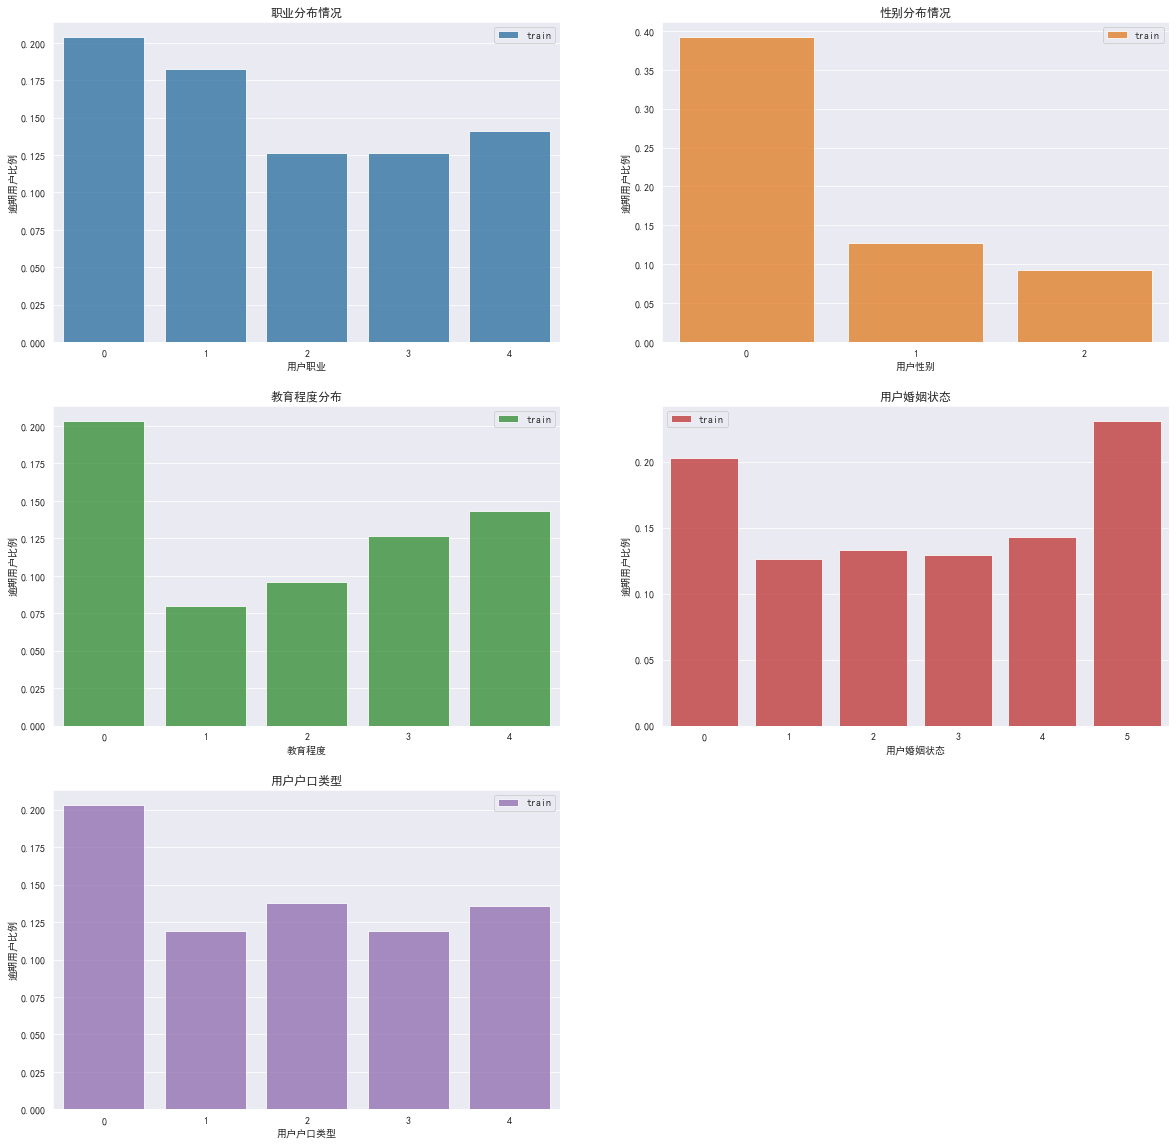

In [24]:
fig = plt.figure(figsize=(20, 20))


ax1 = fig.add_subplot(3, 2, 1)
ax1 = sns.barplot(x=job_distribution.index,
                  y=job_distribution['逾期']/job_distribution['总数'], alpha=0.8, color=p[0], label='train')
ax1.legend()
ax1.set_title(u'职业分布情况')
ax1.set_xlabel(u'用户职业')
ax1.set_ylabel(u'逾期用户比例')

ax2 = fig.add_subplot(3, 2, 2)
ax2 = sns.barplot(x=gender_distribution.index,
                  y=gender_distribution['逾期']/gender_distribution["总数"], alpha=0.8, color=p[1], label='train')
ax2.legend()
ax2.set_title(u'性别分布情况')
ax2.set_xlabel(u'用户性别')
ax2.set_ylabel(u'逾期用户比例')

ax3 = fig.add_subplot(3, 2, 3)
ax3 = sns.barplot(x=education_level.index,
                  y=education_level['逾期']/education_level['总数'], alpha=0.8, color=p[2], label='train')
ax3.legend()
ax3.set_title(u'教育程度分布')
ax3.set_xlabel(u'教育程度')
ax3.set_ylabel(u'逾期用户比例')

ax4 = fig.add_subplot(3, 2, 4)
ax4 = sns.barplot(x=marital_status.index,
                  y=marital_status["逾期"]/marital_status['总数'], alpha=0.8, color=p[3], label='train')
ax4.legend()
ax4.set_title(u'用户婚姻状态')
ax4.set_xlabel(u'用户婚姻状态')
ax4.set_ylabel(u'逾期用户比例')

ax5 = fig.add_subplot(3, 2, 5)
ax5 = sns.barplot(x=hukou_type.index,
                  y=hukou_type['逾期']/hukou_type['总数'], alpha=0.8, color=p[4], label='train')
ax5.legend()
ax5.set_title(u'用户户口类型')
ax5.set_xlabel(u'用户户口类型')
ax5.set_ylabel(u'逾期用户比例')

plt.show()

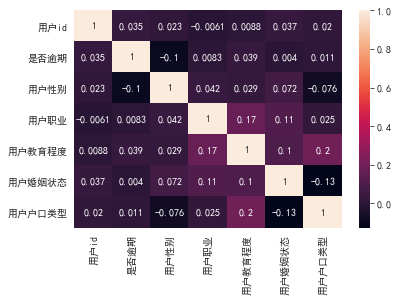

In [25]:
# 热力图
ax6 = sns.heatmap(train_user_info_overdue.corr(),annot=True)

# 银行流水相关

In [26]:
train_bank_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6070197 entries, 0 to 6070196
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   用户id    int64  
 1   流水时间    int64  
 2   交易类型    int64  
 3   交易金额    float64
 4   工资收入标记  int64  
dtypes: float64(1), int64(4)
memory usage: 231.6 MB


In [27]:
train_bank_detail.head()

,用户id,流水时间,交易类型,交易金额,工资收入标记
0,6965,68221,0,13.756664,0
1,6965,68221,1,13.756664,0
2,6965,68258,0,14.449810,0
3,6965,68258,1,10.527763,0
4,6965,68258,1,13.651303,0


<AxesSubplot:>

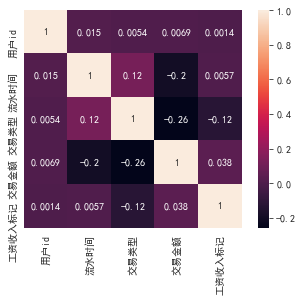

In [28]:
sns.heatmap(train_bank_detail.corr(),square=True,annot=True)

In [29]:
# 工资收入，对应交易类型为0,即收入
train_bank_detail[train_bank_detail["工资收入标记"] == 1]

,用户id,流水时间,交易类型,交易金额,工资收入标记
1632,29165,68278,0,14.847955,1
1684,29165,68309,0,14.717024,1
1740,29165,68341,0,14.637385,1
1785,29165,68370,0,14.911227,1
1824,29165,68401,0,14.931199,1
...,...,...,...,...,...
6069656,15286,68382,0,11.461659,1
6069661,15286,68593,0,7.255079,1
6069668,15286,68594,0,12.840374,1
6069669,15286,68607,0,9.151598,1


In [30]:
train_bank_detail.loc[train_bank_detail["交易类型"] == 1, ["交易类型"]] = -1

In [31]:
train_bank_detail.loc[train_bank_detail["交易类型"] == 0, ["交易类型"]] = 1

In [32]:
train_bank_detail["交易金额"] = train_bank_detail["交易类型"]*train_bank_detail["交易金额"]

In [33]:
train_bank_detail.drop("交易类型", axis=1, inplace=True)

In [34]:
train_bank_detail.head()

,用户id,流水时间,交易金额,工资收入标记
0,6965,68221,13.756664,0
1,6965,68221,-13.756664,0
2,6965,68258,14.449810,0
3,6965,68258,-10.527763,0
4,6965,68258,-13.651303,0


In [35]:
train_bank_detail_table = train_bank_detail.loc[:, [
    "用户id", "交易金额"]].groupby("用户id").sum()

In [36]:
train_bank_detail_table = pd.merge(
    train_bank_detail_table, train_overdue, how="inner", on="用户id")

In [37]:
train_bank_detail_table.head()

,用户id,交易金额,是否逾期
0,1,-195.332507,0
1,3,-2707.084161,0
2,4,-965.083338,1
3,9,45.288586,0
4,10,-456.650397,0


<AxesSubplot:ylabel='交易金额'>

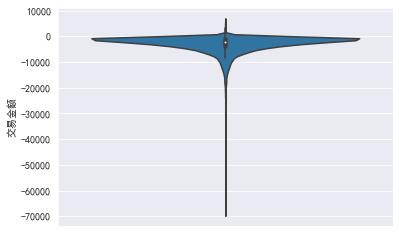

In [38]:
sns.violinplot(y="交易金额", data=train_bank_detail_table)

D:\learn\anaconda3\envs\learn\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='交易金额', ylabel='Density'>

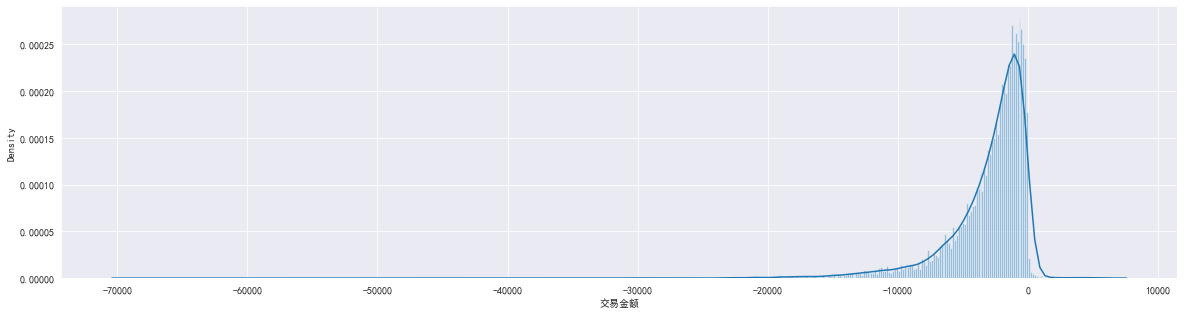

In [41]:
plt.figure(figsize=(20,5))
sns.distplot(train_bank_detail_table["交易金额"],bins=500)

<AxesSubplot:xlabel='是否逾期', ylabel='交易金额'>

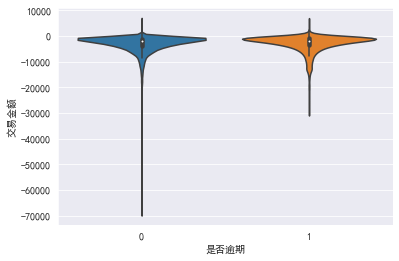

In [39]:
sns.violinplot(x="是否逾期", y="交易金额", data=train_bank_detail_table)

<AxesSubplot:xlabel='交易金额', ylabel='是否逾期'>

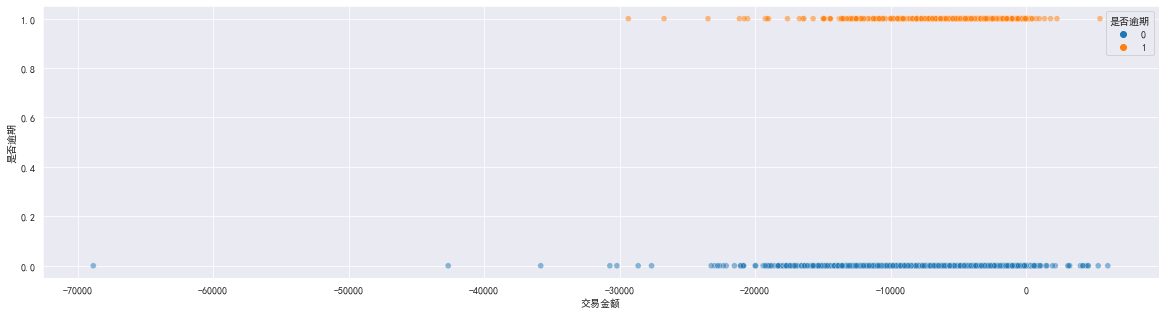

In [40]:
plt.figure(figsize=(20, 5))
sns.scatterplot(x="交易金额", y="是否逾期", hue="是否逾期",
                data=train_bank_detail_table, alpha=0.5)

# 用户浏览记录相关

In [43]:
train_browse_history.head()

,用户id,浏览时间,浏览行为数据,浏览子行为编号
0,34801,68588,173,1
1,34801,68588,164,4
2,34801,68588,38,7
3,34801,68588,45,1
4,34801,68588,110,7


In [44]:
train_browse_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22919547 entries, 0 to 22919546
Data columns (total 4 columns):
 #   Column   Dtype
---  ------   -----
 0   用户id     int64
 1   浏览时间     int64
 2   浏览行为数据   int64
 3   浏览子行为编号  int64
dtypes: int64(4)
memory usage: 699.4 MB


In [45]:
train_browse_history.loc[:, ["用户id", "浏览时间"]].groupby(
    "用户id", as_index=False).sum().rename(columns={"浏览时间": "count"})

,用户id,count
0,2,89097660
1,3,23342202
2,4,24845096
3,6,1024625
4,7,68877200
...,...,...
47325,55592,27184788
47326,55593,12287296
47327,55594,65832760
47328,55595,43195950


In [46]:
train_browse_history_table =  train_browse_history.loc[:, ["用户id", "浏览时间"]].groupby(
    "用户id", as_index=False).sum().rename(columns={"浏览时间": "count"})

In [47]:
train_browse_history_table = train_browse_history_table.merge(train_overdue,how = "inner",on = "用户id")

In [48]:
train_browse_history_table.head()

,用户id,count,是否逾期
0,2,89097660,0
1,3,23342202,0
2,4,24845096,1
3,6,1024625,1
4,7,68877200,0


D:\learn\anaconda3\envs\learn\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\learn\anaconda3\envs\learn\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '逾期用户的浏览记录数量分布')

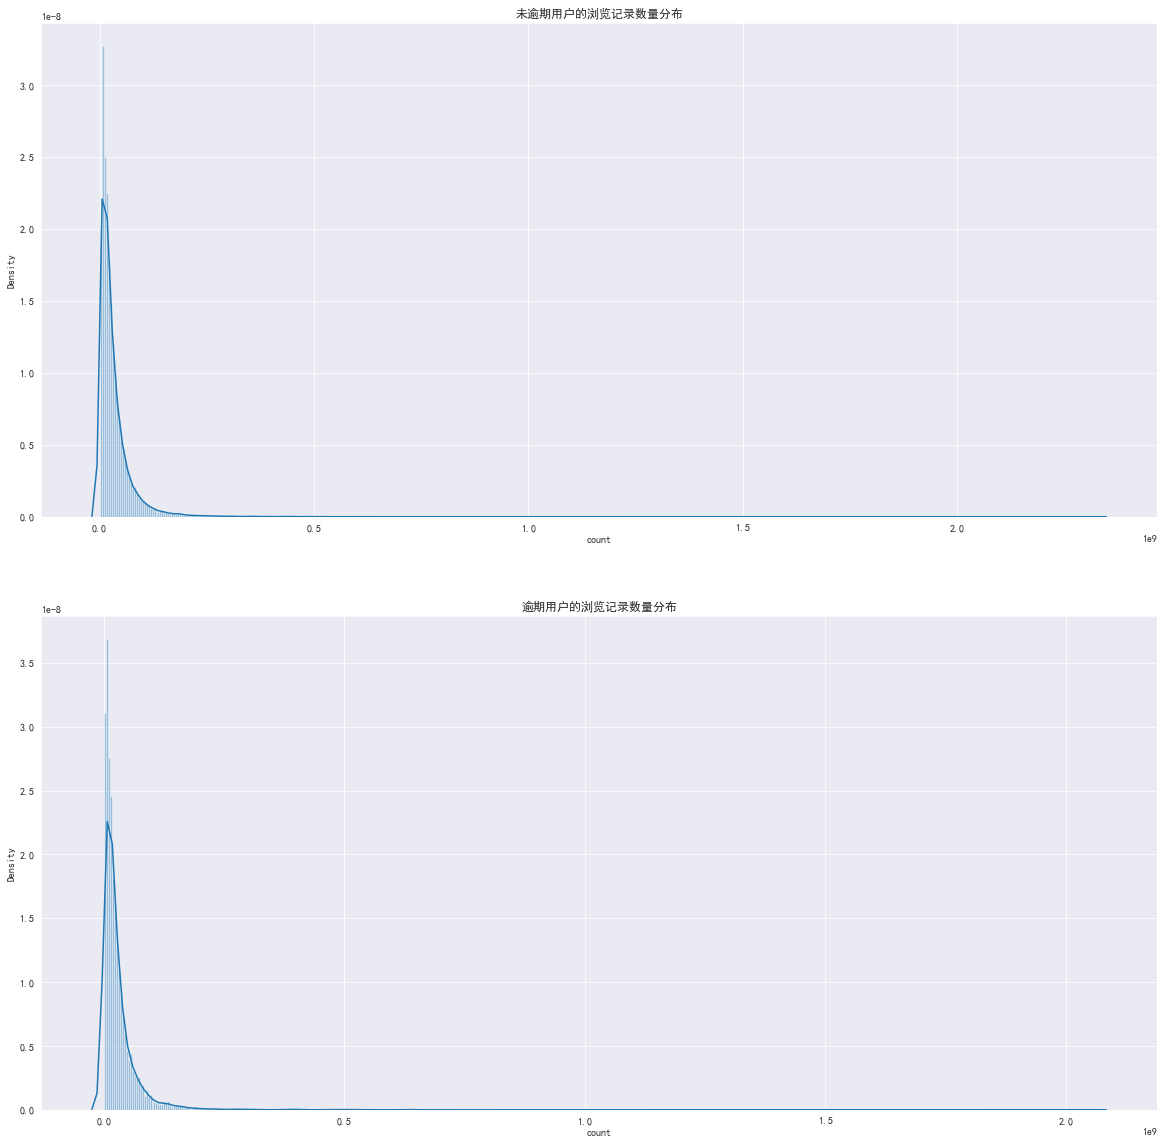

In [49]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2, 1, 1)
ax1 = sns.distplot(train_browse_history_table["count"][train_browse_history_table["是否逾期"]==0],bins=500)
ax1.set_title("未逾期用户的浏览记录数量分布")

ax1 = fig.add_subplot(2, 1, 2)
ax2 = sns.distplot(train_browse_history_table["count"][train_browse_history_table["是否逾期"]==1],bins=500)
ax1.set_title("逾期用户的浏览记录数量分布")

# 信用卡账单

In [50]:
train_bill_detail.head()

,用户id,时间,银行标识,上期账单金额,上期还款金额,信用卡额度,本期账单余额,本期账单最低还款额,消费笔数,本期账单金额,调整金额,循环利息,可用余额,预借现金额度,还款状态
0,3150,68365,6,18.626118,18.661937,20.664418,18.905766,17.847133,1,0.0,0.0,0.0,0.0,19.971271,0
1,3150,68365,6,18.905766,18.909954,20.664418,19.113305,17.911506,1,0.0,0.0,0.0,0.0,19.971271,0
2,3150,68365,6,19.113305,19.150290,20.664418,19.300194,17.977610,1,0.0,0.0,0.0,0.0,19.971271,0
3,3150,68365,6,19.300194,19.300280,21.000890,20.303240,18.477177,1,0.0,0.0,0.0,0.0,20.307743,0
4,3150,68365,6,20.303240,20.307744,21.000890,20.357134,18.510985,1,0.0,0.0,0.0,0.0,20.307743,0


In [51]:
train_bill_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338118 entries, 0 to 2338117
Data columns (total 15 columns):
 #   Column     Dtype  
---  ------     -----  
 0   用户id       int64  
 1   时间         int64  
 2   银行标识       int64  
 3   上期账单金额     float64
 4   上期还款金额     float64
 5   信用卡额度      float64
 6   本期账单余额     float64
 7   本期账单最低还款额  float64
 8   消费笔数       int64  
 9   本期账单金额     float64
 10  调整金额       float64
 11  循环利息       float64
 12  可用余额       float64
 13  预借现金额度     float64
 14  还款状态       int64  
dtypes: float64(10), int64(5)
memory usage: 267.6 MB


In [52]:
train_bill_detail_table = train_bill_detail.merge(train_overdue,on = "用户id")

<AxesSubplot:>

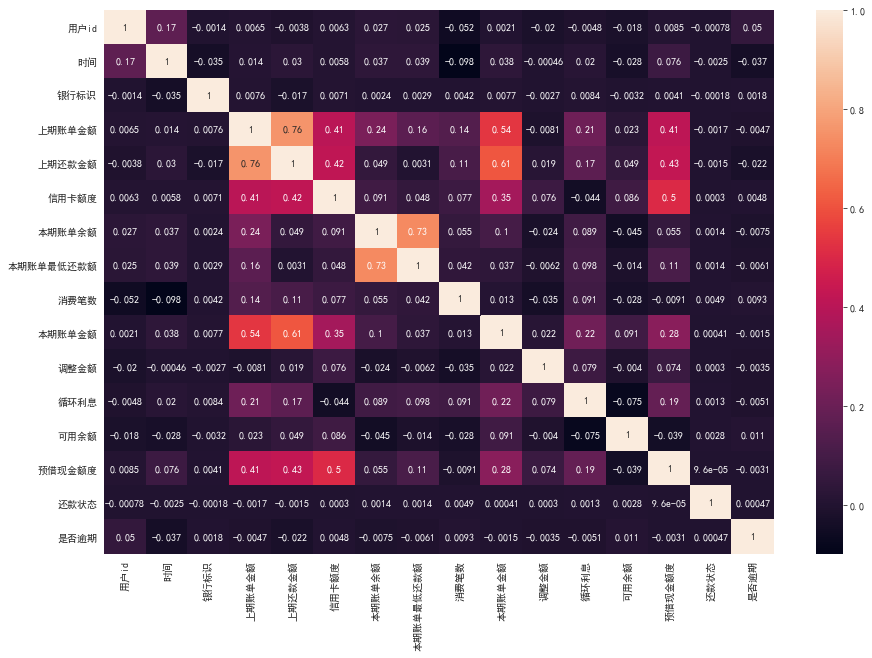

In [53]:
plt.figure(figsize=(15,10))
sns.heatmap(train_bill_detail_table.corr(),annot=True)